In [17]:
# !pip install mlxtend

In [2]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import copy

import sklearn
print(sklearn.__version__)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score,  roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier

from xgboost import XGBRegressor, plot_importance
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE, KMeansSMOTE, SMOTEN, SMOTENC, SVMSMOTE

from mlxtend.plotting import plot_learning_curves

import matplotlib.pyplot as plt

1.1.1


In [3]:
path = os.getcwd()
path

'/home/fabio/Documents/tabular_lesion'

In [ ]:
class WorkingSet:
    def __init__(self, csv_file_name:str):
        self.imported_dataframe = pd.read_csv(csv_file_name)
        self.training_df = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.target_name = ''
        self.generate_train_set()
        self.generate_test_set()
    
    def generate_train_set(self):
        
        df_train = self.imported_dataframe[self.imported_dataframe['Inf_Train_test'].str.contains('train', case=False)]
        df_valid = self.imported_dataframe[self.imported_dataframe['Inf_Train_test'].str.contains('valid', case=False)]

        self.training_df = pd.concat([df_train, df_valid], axis=0)
        
        print(f'Are thre any Nan = {self.training_df.isnull().values.any()}, Number of Nan = {self.training_df.isnull().sum().sum()}')

        for key in self.training_df.keys():
            if 'target' in key.lower():
                self.target_name = key
                print(self.target_name)
        
        self.X_train = self.training_df.drop(['Target_Lesion_ClinSig', 'Inf_Train_test'], axis=1)
        self.y_train = self.training_df['Target_Lesion_ClinSig']

    def generate_test_set(self):
        df_test = self.imported_dataframe[self.imported_dataframe['Inf_Train_test'].str.contains('test', case=False)]
        self.X_test = df_test.drop(['Target_Lesion_ClinSig', 'Inf_Train_test'], axis=1)
        self.y_test = df_test['Target_Lesion_ClinSig']
    
all_set = WorkingSet('lesion_df_balanced_Target_Lesion_ClinSig.csv')

Are thre any Nan = False, Number of Nan = 0
Target_Lesion_ClinSig


In [6]:
all_set.training_df.head()

,Inf_Train_test,Target_Lesion_ClinSig,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_123,Feature_124,Feature_125,Feature_126,Feature_127,Feature_128,Feature_129,Feature_130,Feature_131,Feature_132
0,train,1,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,...,13.011402,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769
1,train,1,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,...,13.011402,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769
2,train,1,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,...,13.011402,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769
3,train,1,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,...,13.011402,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769
4,train,1,0.0,0.0,-1.0,-1.000000e+10,0.0,0.0,0.0,0.0,...,13.011402,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769


In [11]:
def plot_class_balance(all_set: WorkingSet):
    df_Clinically_Sig = pd.DataFrame(all_set.training_df[all_set.target_name].value_counts())
    df_Clinically_Sig.reset_index(inplace=True)
    df_Clinically_Sig = df_Clinically_Sig.rename(columns = {'index':'Clinically_Sig'})
    df_Clinically_Sig = df_Clinically_Sig.rename(columns = {all_set.target_name:'Count'})

    fig = px.bar(df_Clinically_Sig, x='Clinically_Sig', y='Count', color=('blue', 'red'), text='Count', title='Class Balance')
    fig.update_layout(showlegend=False)
    fig.show(renderer="colab")

plot_class_balance(all_set)

In [9]:
# import importlib
# import imblearn
# from imblearn import over_sampling as os
# for class_name in os.__all__[:6]:
#     module = importlib.import_module('imblearn.over_sampling')
#     class_ = getattr(module, class_name)
#     sampling = class_
#     print(sampling())
# os.__all__

In [13]:
assert all_set.X_train.shape[0] == all_set.y_train.shape[0]
assert all_set.X_test.shape[0] == all_set.y_test.shape[0]

In [14]:
smote = ADASYN(random_state=2022, sampling_strategy='minority', n_jobs=4)
X_train, y_train = smote.fit_resample(all_set.X_train.values, all_set.y_train.values.ravel())

In [15]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights

array([1.00026388, 0.99973626])

In [ ]:
autoscaler = StandardScaler()

LR = LogisticRegression(random_state=2022, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        n_jobs=4, 
                        l1_ratio=0.25, 
                       )
LRparam_grid = {
    'l1_ratio': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25],
    'C': [0.00001, 0.0001, 0.001, 0.01],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start' : [True, False]
}

LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 1, cv=5)

scaled_X_train = autoscaler.fit_transform(X_train)

LR_search.fit(scaled_X_train , y_train)
LR_search.best_params_
# summarize
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)


Fitting 5 folds for each of 168 candidates, totalling 840 fits
Mean Accuracy: 0.863
Config: {'C': 0.001, 'l1_ratio': 0.175, 'multi_class': 'auto', 'warm_start': True}


In [48]:
class RocCurve:
    def __init__(self, model: sklearn, all_set: WorkingSet):
        self.model = model
        self.all_set = all_set
        fpr_lr_train, tpr_lr_train, roc_auc_lr_train = self.generate_score(all_set.X_train, all_set.y_train)
        fpr_lr_test, tpr_lr_test, roc_auc_lr_test = self.generate_score(all_set.X_test, all_set.y_test)
        self.plot_roc_curve(fpr_lr_train, tpr_lr_train, roc_auc_lr_train, fpr_lr_test, tpr_lr_test, roc_auc_lr_test)
    
    def generate_score(self, x_set, y_set):
        y_scores = self.model.decision_function(autoscaler.fit_transform(x_set.values))
        
        fpr_lr, tpr_lr, _ = roc_curve(y_set.values.ravel(), y_scores)
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        
        return fpr_lr, tpr_lr, roc_auc_lr
    
    @staticmethod
    def plot_roc_curve(fpr_lr_train, tpr_lr_train, roc_auc_lr_train, fpr_lr_test, tpr_lr_test, roc_auc_lr_test):
        
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,7))
        ax1.set_title('ROC curve Train', fontsize=16)
        ax1.plot(fpr_lr_train, tpr_lr_train, lw=3, label=f'LogRegr ROC curve (area = {roc_auc_lr_train:0.2f})')
        ax1.set_xlabel('False Positive Rate', fontsize=16)
        ax1.set_ylabel('True Positive Rate', fontsize=16)
        ax1.legend(loc='lower right', fontsize=13)
        ax1.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        
        ax2.set_title('ROC curve Test', fontsize=16)
        ax2.plot(fpr_lr_test, tpr_lr_test, lw=3, label=f'LogRegr ROC curve (area = {roc_auc_lr_test:0.2f})')
        ax2.set_xlabel('False Positive Rate', fontsize=16)
        ax2.set_ylabel('True Positive Rate', fontsize=16)
        ax2.legend(loc='lower right', fontsize=13)
        ax2.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')  

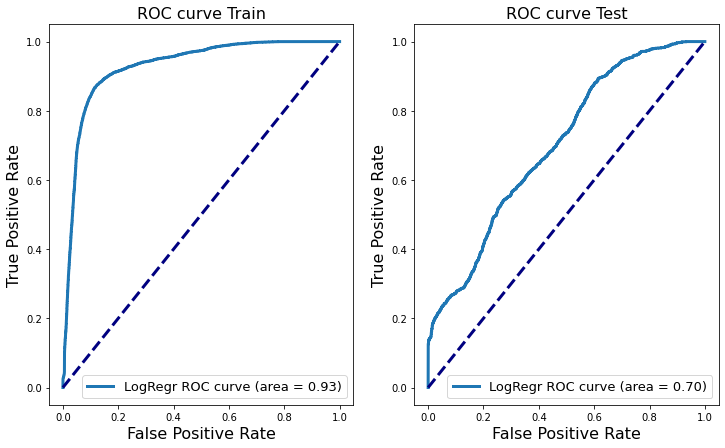

In [49]:
RocCurve(LR_search, all_set)   

In [62]:
X_train_s, X_test_s, y_train_s,  y_test_s = train_test_split(scaled_X_train, y_train, test_size=0.05, random_state=2022)
X_train_s.shape, X_test_s.shape, y_train_s.shape,  y_test_s.shape

((50414, 132), (2654, 132), (50414,), (2654,))

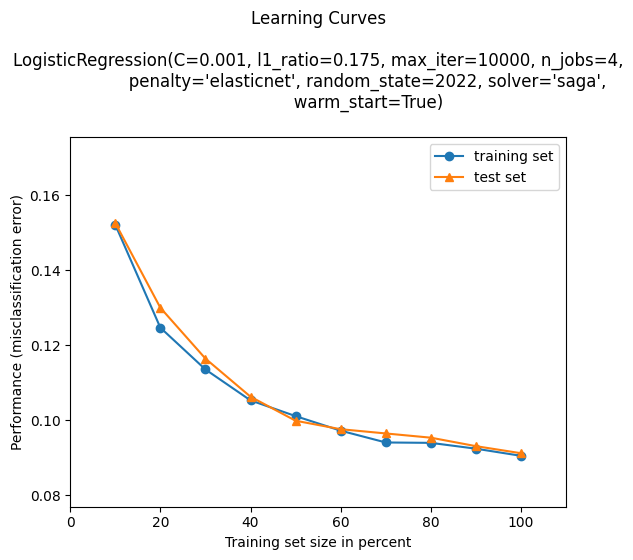

In [63]:
plot_learning_curves(X_train_s, y_train_s, X_test_s,  y_test_s, LR_search.best_estimator_)
plt.show()

In [67]:
# model.fit(autoscaler.fit_transform(X_train), y_train)
# get importance
importance = LR_search.best_estimator_.coef_[0]

<BarContainer object of 132 artists>

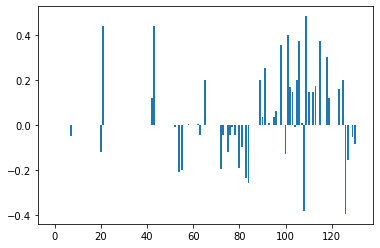

In [69]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
# pyplot.show()

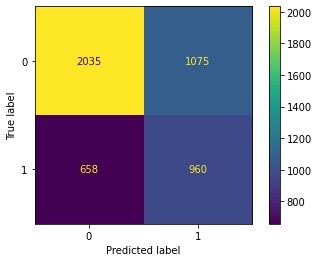

In [64]:
predictions = LR_search.best_estimator_.predict(autoscaler.fit_transform(all_set.X_test.values))
cm = confusion_matrix(all_set.y_test.values.ravel(), predictions, labels=LR_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_search.best_estimator_.classes_)
disp.plot()

In [65]:
val_acc = accuracy_score(all_set.y_test.values.ravel(), predictions)
val_f1 = f1_score(all_set.y_test.values.ravel(), predictions)
print(f"Acc: {val_acc} | F1: {val_f1}")

Acc: 0.6334602368866328 | F1: 0.525595401040241


In [66]:
target_names = ['class 0', 'class 1']
print(classification_report(all_set.y_test.values.ravel(), predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.76      0.65      0.70      3110
     class 1       0.47      0.59      0.53      1618

    accuracy                           0.63      4728
   macro avg       0.61      0.62      0.61      4728
weighted avg       0.66      0.63      0.64      4728



In [84]:
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion, Pipeline

In [83]:
# transforms for the feature union
transforms = list()
transforms.append(('mms', MinMaxScaler()))
transforms.append(('ss', StandardScaler()))
transforms.append(('rs', RobustScaler()))
transforms.append(('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')))
transforms.append(('kbd', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')))
transforms.append(('pca', PCA(n_components=7)))
transforms.append(('svd', TruncatedSVD(n_components=7)))
# create the feature union
fu = FeatureUnion(transforms)

In [92]:
from sklearn.feature_selection import RFE
# define the feature selection
rfe = RFE(estimator=LR_search.best_estimator_, n_features_to_select=70)

In [93]:
# define the pipeline
steps = list()
steps.append(('fu', fu))
steps.append(('rfe', rfe))
steps.append(('m', LR_search.best_estimator_))
pipeline = Pipeline(steps=steps)

In [95]:
from sklearn.model_selection import RepeatedStratifiedKFold
# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2022)

In [ ]:
from sklearn.model_selection import cross_val_score
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=4)

In [ ]:
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

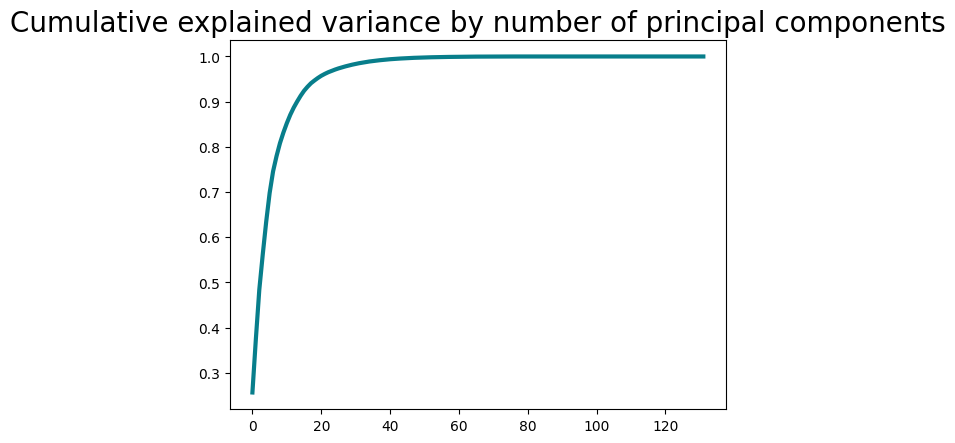

In [124]:


pca = PCA().fit(scaled_X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [139]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(df_X_train.columns) + 1)],
    index=df_X_train.columns
)
loadings[0:10].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132
Feature_lesion_P_tz_abs,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,4.038151e-16,-0.000000e+00
Feature_lesion_P_tz_div_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,1.675625e-17,-6.124534e-18,3.373118e-18,-1.264551e-17,-2.135140e-17,1.490095e-19,-1.959527e-17,-1.930130e-17,1.485542e-17,1.795535e-17
Feature_lesion_P_tz_sub_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,-1.491828e-17,-4.769275e-19,-1.695741e-18,-6.247319e-17,3.505093e-18,1.302507e-17,-5.067165e-17,-5.686721e-17,-4.710640e-17,-1.235414e-17
Feature_lesion_P_tz_std_mean_P_tz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,-2.713736e-17,4.822052e-17,-1.536715e-17,5.905228e-17,3.232089e-17,2.054463e-17,3.610010e-17,3.543143e-17,-1.793844e-17,6.387351e-17
Feature_lesion_P_tz_div_mean_P_pz,-0.858393,-0.408962,-0.228816,-0.06421,0.016883,0.124546,0.110268,-0.061746,-0.031073,-0.059326,...,6.613031e-17,-4.251325e-17,1.834826e-17,7.192436e-17,-4.923234e-17,5.027064e-17,2.361233e-17,-9.982232e-18,-1.813166e-17,-1.269122e-17


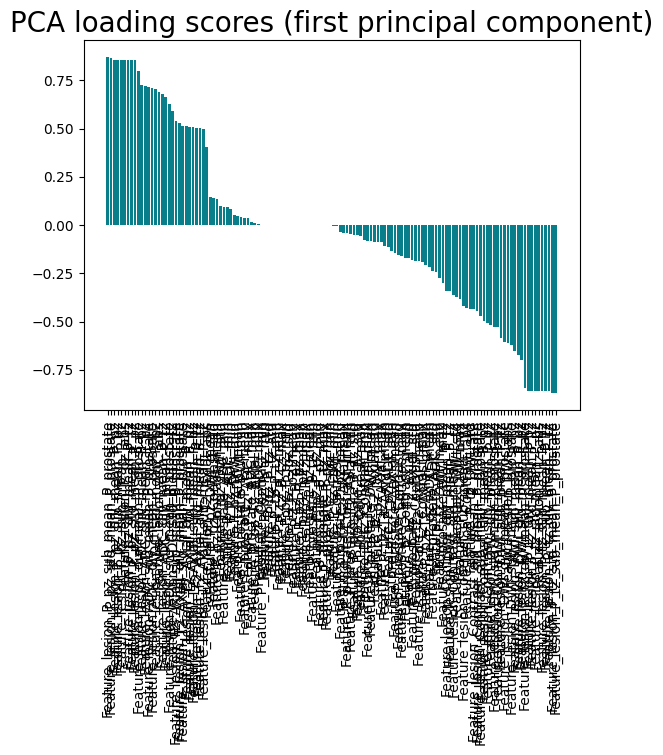

In [140]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [141]:
# Import the necessary libraries first


In [143]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(abs(scaled_X_train), y_train)

In [144]:
# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01
 3.817e+02 4.893e-01 5.782e+01       nan       nan       nan       nan
       nan       nan       nan       nan       nan       nan 9.949e+02
 1.876e+03 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01 6.847e+01
 6.847e+01 1.428e+03 4.893e-01 5.782e+01       nan       nan       nan
       nan       nan       nan       nan       nan       nan       nan
 9.949e+02 1.876e+03 9.664e+02 2.458e+02 6.535e+02 4.556e+02 9.954e+01
 2.746e+01 6.268e+00 2.455e+02 6.320e+01 5.821e+02 1.014e+02 9.310e+02
 9.705e+02 7.870e+02 4.504e+02 5.241e+02 4.024e+01 1.681e+02 1.430e+02
 1.069e+03 6.005e+01 9.081e+01 4.239e+02 3.819e+02 4.008e+02 2.534e+02
 3.958e+02 1.450e+02 1.656e+02 4.689e+02 3.034e+02 5.526e+02 1.779e+01
 4.043e+02 2.316e+02 5.101e+02 5.356e+02 9.181e+02 1.125e+00 5.078e+02
 6.591e+02 3.825e+02 1.471e+00 6.168e+00 3.889e+00 1.388e+00 6.194e+00
 7.494e+00 2.494e+00 7.252e+00 3.656e+01 1.324e+01 8.983e-02 6.096e+01
 6.981

In [147]:
features = fit.transform(abs(scaled_X_train))
# Summarize selected features
print(features[0:5,:])

[[0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]
 [0.642 0.642 0.078 1.613]]


In [148]:
if smote_flag:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            C = 0.001
                           )
else:
    LR_best = LogisticRegression(random_state=2022, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            n_jobs=4, 
                            l1_ratio=0.25, 
                            class_weight={0:0.63640819, 1:2.33273456},
                            C = 0.001
                           )

In [152]:
from sklearn.feature_selection import RFE

In [162]:
rfe = RFE(LR_best, n_features_to_select=75, step=1)

In [163]:
fit = rfe.fit(scaled_X_train, y_train)

In [164]:
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 75
Selected Features: [False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False  True  True False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False False False False False
  True  True False  True  True False  True False  True  True False  True
  True False  True  True  True  True  True  True  True  True False  True
  True False  True False  True  True  True  True False  True  True False
  True  True  True False  True  True False  True False False  True  True
 False False False  True  True  True  True  True  True  True  True False]
Feature Ranking: [58 57 56 55 54 53 52  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  4  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35  1  1 38 41 40 

In [186]:
# First things first


In [206]:
ridge = RidgeClassifier(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=10000, random_state=2022, solver='auto', tol=0.001)

In [207]:
ridge.fit(scaled_X_train, y_train)

RidgeClassifier(alpha=0.01, max_iter=10000, random_state=2022)

In [208]:
def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

In [209]:
# print ("Ridge model:", pretty_print_coefs(ridge.coef_))

In [210]:
# for idx, coeff in enumerate(ridge.coef_):
#     if coeff > 0.05:
#         print(idx, coeff)

In [211]:
np.std(ridge.coef_), np.mean(ridge.coef_), np.median(ridge.coef_)

(1.068076653781554, -0.012327575757865689, 0.0)

In [212]:
y_pred = ridge.predict(autoscaler.fit_transform(df_X_test.values))

In [213]:
y_pred

array([1, 1, 1, ..., 0, 0, 0])

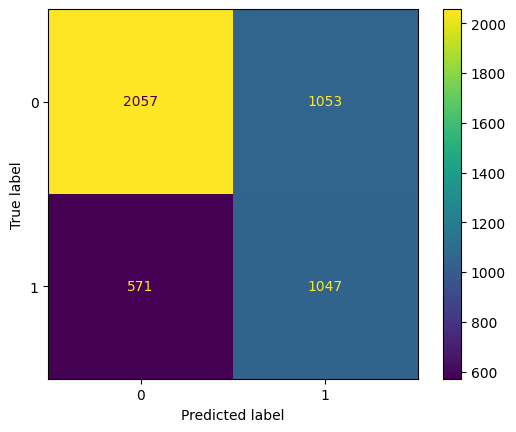

In [214]:
cm = confusion_matrix(df_y_test.values.ravel(), y_pred, labels=ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge.classes_)
disp.plot()

In [215]:
target_names = ['class 0', 'class 1']
print(classification_report(df_y_test.values.ravel(), y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.66      0.72      3110
     class 1       0.50      0.65      0.56      1618

    accuracy                           0.66      4728
   macro avg       0.64      0.65      0.64      4728
weighted avg       0.69      0.66      0.66      4728



In [216]:
val_acc = accuracy_score(df_y_test.values.ravel(), y_pred)
val_f1 = f1_score(df_y_test.values.ravel(), y_pred)
print(f"Acc: {val_acc} | F1: {val_f1}")

Acc: 0.6565143824027073 | F1: 0.5632060247444862


In [122]:
# df_concat = pd.concat([df_X_train, df_y_train], axis=1)
# df_corr = df_concat.corr()

In [ ]:
threshold = 0.90


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df_concat.columns[columns]
selected_columns
df_training = df_concat[selected_columns]

In [ ]:
df_training.shape, df_concat.shape

In [ ]:
lst_diff = df_concat.columns.difference(df_training.columns)
len(lst_diff)

In [ ]:
corr_X = df_training.drop('Target_Lesion_ClinSig', axis=1)
corr_y = df_training['Target_Lesion_ClinSig']

In [ ]:
model.fit(autoscaler.fit_transform(corr_X.values), corr_y.values.ravel())
# get importance
importance = model.coef_[0]

In [ ]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
df_X_test_corr = df_X_test.drop(lst_diff, axis=1)

predictions = model.predict(autoscaler.fit_transform(df_X_test_corr.values))
cm = confusion_matrix(df_y_test.values.ravel(), predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
val_acc = accuracy_score(df_y_test.values.ravel(), predictions)
val_f1 = f1_score(df_y_test.values.ravel(), predictions)
print(f"Acc: {val_acc} | F1: {val_f1}")

In [ ]:
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [ ]:
featfig = pyplot.figure(figsize=(12, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(corr_X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')